In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

In [2]:
import numpy as np

In [3]:
import gudhi
from gudhi import hera
from gudhi import wasserstein
import ot

In [4]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='iframe'

In [5]:
from vineyard import *

In [6]:
%load_ext autoreload
%autoreload 2

## CNN

In [7]:
batch_size = 128
epochs = 10
learning_rate = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

test_loader = DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transform),
)

In [27]:
class CNN(nn.Module):
    def __init__(self, c1, c2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, c1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(c1, c2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(c2*7*7, 10),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        c1 = self.conv1(x)
        c2 = self.conv2(c1)
        y = self.fc(c2.view(c2.shape[0], -1))
        return y, (x, c1, c2)
    
    def loss(self, y_pred, y):
        return nn.CrossEntropyLoss()(y_pred, y)

In [28]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, _ = model(images)
            pred_y = torch.max(test_output, 1)[1].data
            
            correct += (pred_y == labels).squeeze().item()
            total += labels.shape[0]

        return correct/total

In [121]:
def train(model, optimizer, train_loader, epochs, track_imgs, max_batch=np.inf, track=False):
    sfxs = []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            if batch_idx >= max_batch: return sfxs
            
            data = data.to(device)
            optimizer.zero_grad()
            
            #recon_batch, mu, logvar = model(data)
            #loss = loss_function(recon_batch, data, mu, logvar)

            y_pred, _ = model(data)
            loss = model.loss(y_pred, labels)

            
            
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
            
            if track:
                with torch.no_grad():
                    sfxs.append(model(track_imgs)[1])

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item()/len(data)}")

            

        print(f"====> Epoch {epoch+1}/{epochs}, Average Loss: {total_loss / len(train_loader.dataset)}")

    return sfxs

In [105]:
# torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),}, 'cnn_model_prune.pth')
# checkpoint = torch.load('cnn_model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

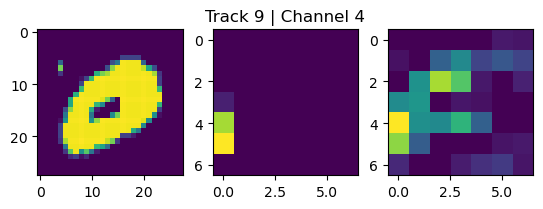

In [30]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(Xs[-1,ti,0])
axs[1].imshow(c2s[0,ti,ch])
axs[2].imshow(c2s[-1,ti,ch])
axs[1].set_title(f"Track {ti} | Channel {4}")
plt.show()

In [44]:
c1s[0,0,0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [71]:
def vdist_channel(conv, channel, pdim=0, verbose=0):
    return np.mean([
        vdist(vineyard(np.arange(conv.shape[0]), conv[:,i,channel], fmax=torch.max(conv), method=gudhi.wasserstein, dim=pdim, verbose=verbose))
    for i in range(track)]) 

def L2_channel(conv, channel, pdim=0, verbose=0):
    return np.mean([
        torch.norm(conv[0,i,channel]-conv[-1,i,channel], p=2)
    for i in range(track)])  

def Winf1_channel(conv, ch, pdim=0, verbose=0, method=gudhi.wasserstein):
    return np.mean([
        method.wasserstein_distance(persistence(conv[0,i,ch], dimension=pdim), persistence(conv[-1,i,ch], dimension=pdim), internal_p=np.inf, order=1)
    for i in range(track)])  

In [162]:
def plot_channel_analysis(sz, vdcs, title=""):
    plt.plot(range(sz), vdcs[:,0], label="Vineyard")
    plt.plot(range(sz), vdcs[:,1], label="L2")
    plt.plot(range(sz), vdcs[:,2], label="Winf1")
    plt.xlabel("Channel")
    plt.ylabel("Distance")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.00, 1.00))
    plt.show()
    
def channel_analysis(conv, title=""):
    vdcs = np.array([[
        vdist_channel(conv, c, pdim=0),
        L2_channel(conv, c, pdim=0),
        Winf1_channel(conv, c, pdim=0)
    ] for c in range(conv.shape[2])])

    plot_channel_analysis(conv.shape[2], vdcs, title=title)
    vdcs_st = (vdcs-np.mean(vdcs, axis=0))/np.std(vdcs, axis=0, ddof=1)

    plt.plot([0, conv.shape[2]-1], [2,2], "--", label="Cutoff")
    plot_channel_analysis(conv.shape[2], vdcs_st, title=title)
    
    return vdcs

In [170]:
def trial(cs, learning_rate=0.01, max_batch=64, track=True, verbose=2):
    track = 30
    track_imgs = None
    for images, labels in train_loader:
        track_imgs = images[:track]
        break

    if verbose > 1: print("train")
    model = CNN(cs[0], cs[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    sfxs = train(model, optimizer, train_loader, epochs, track_imgs, max_batch=max_batch, track=track)

    if verbose > 1: print("test")
    acc = test(model)

    if not track: return acc
    
    sfxs = [[s.detach() for s in sfx] for sfx in sfxs]
    c1s = torch.stack([sfx[1] for sfx in sfxs])
    c2s = torch.stack([sfx[2] for sfx in sfxs])
    Xs = torch.stack([sfx[0] for sfx in sfxs])

    c1, c2 = None, None
    if verbose > 0:
        if verbose > 1: print("conv1")
        c1 = channel_analysis(c1s, title="Epoch-H VD(): Conv1")

        if verbose > 1: print("conv2")
        c2 = channel_analysis(c2s, title="Epoch-H VD(): Conv2")
        relevant = np.sum(c2 >= (np.mean(c2, axis=0)+2*np.std(c2, axis=0)), axis=0)

    return acc, relevant, (c1, c2, sfxs, c1s, c2s, Xs)

train
Epoch 1/10, Batch 0, Loss: 0.01808975078165531
Epoch 1/10, Batch 10, Loss: 0.015018912963569164
Epoch 1/10, Batch 20, Loss: 0.004857396241277456
Epoch 1/10, Batch 30, Loss: 0.002762800082564354
Epoch 1/10, Batch 40, Loss: 0.0023371148854494095
Epoch 1/10, Batch 50, Loss: 0.00301724998280406
Epoch 1/10, Batch 60, Loss: 0.0014706369256600738
Epoch 1/10, Batch 70, Loss: 0.001453164964914322
Epoch 1/10, Batch 80, Loss: 0.002190822036936879
Epoch 1/10, Batch 90, Loss: 0.002343726810067892
Epoch 1/10, Batch 100, Loss: 0.001663900213316083
Epoch 1/10, Batch 110, Loss: 0.0007931414875201881
Epoch 1/10, Batch 120, Loss: 0.0018746113637462258
test
conv1


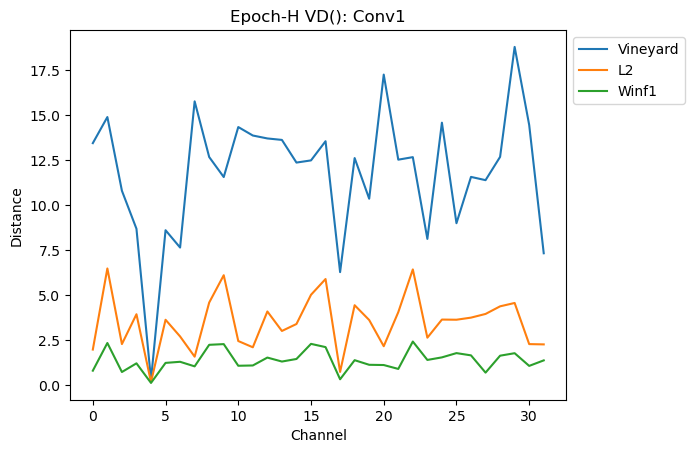

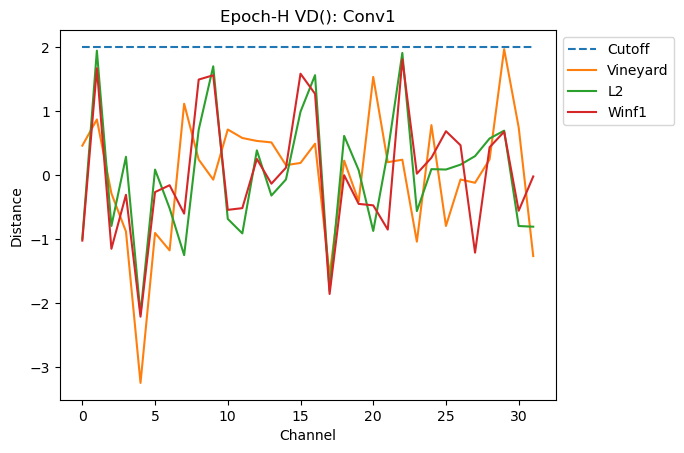

conv2


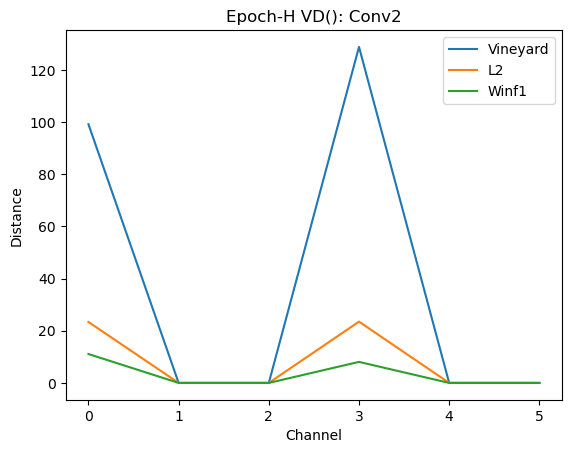

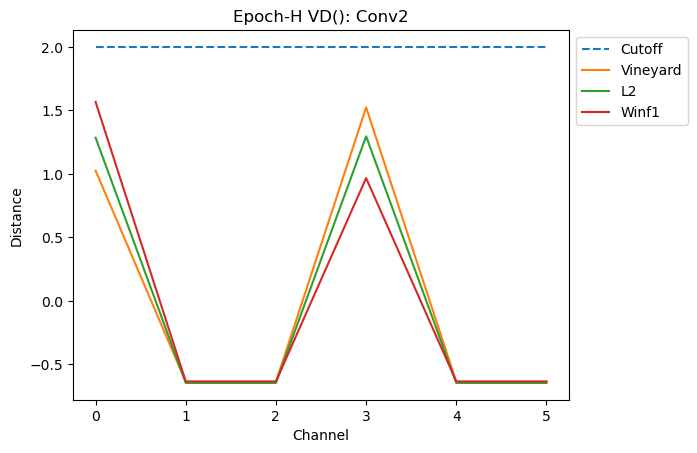

train
Epoch 1/10, Batch 0, Loss: 0.017930224537849426
Epoch 1/10, Batch 10, Loss: 0.0112724918872118
Epoch 1/10, Batch 20, Loss: 0.005221034400165081
Epoch 1/10, Batch 30, Loss: 0.0035223925951868296
Epoch 1/10, Batch 40, Loss: 0.0026171868667006493
Epoch 1/10, Batch 50, Loss: 0.001939027919434011
Epoch 1/10, Batch 60, Loss: 0.002019813284277916
Epoch 1/10, Batch 70, Loss: 0.0018692663870751858
Epoch 1/10, Batch 80, Loss: 0.0024441443383693695
Epoch 1/10, Batch 90, Loss: 0.00189348089043051
Epoch 1/10, Batch 100, Loss: 0.0016567526618018746
Epoch 1/10, Batch 110, Loss: 0.0021433394867926836
Epoch 1/10, Batch 120, Loss: 0.0019232395570725203
test
conv1


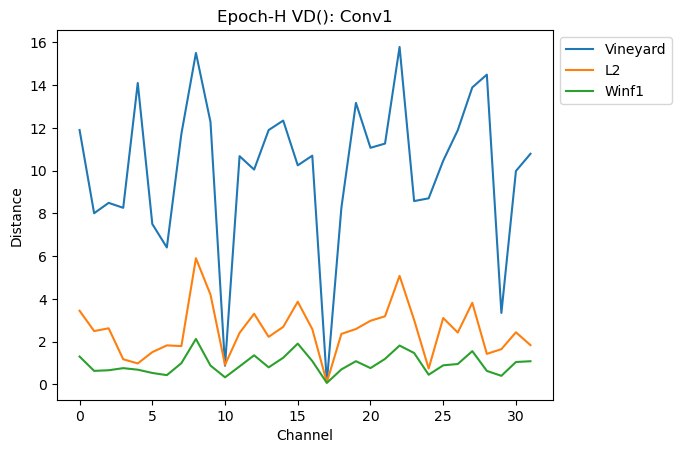

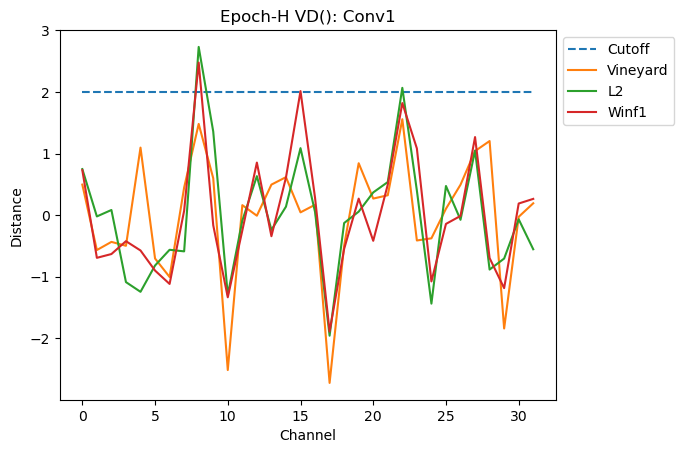

conv2


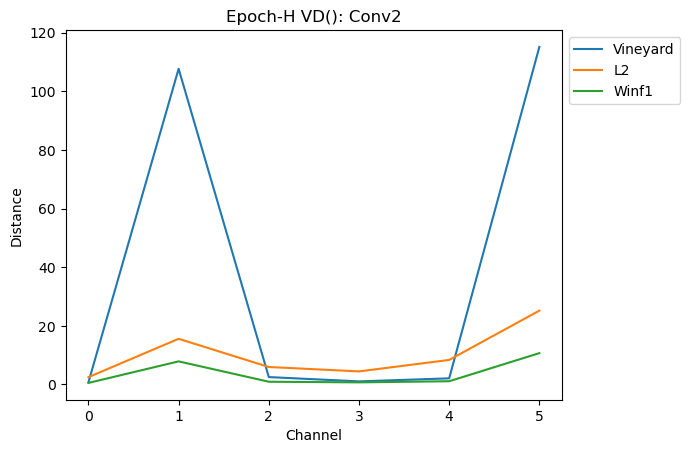

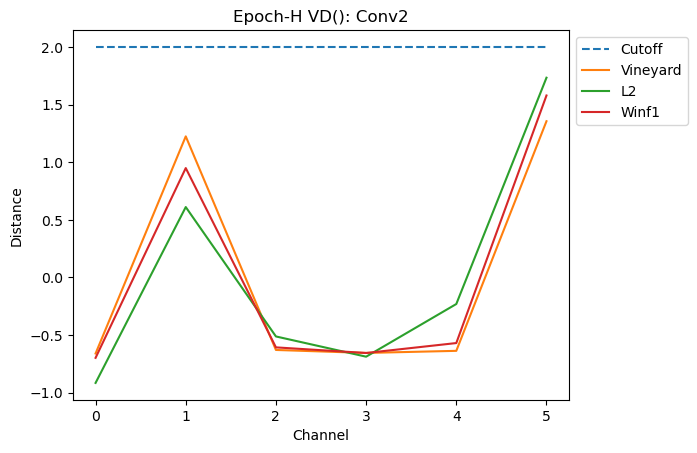

train
Epoch 1/10, Batch 0, Loss: 0.018056970089673996
Epoch 1/10, Batch 10, Loss: 0.010054564103484154
Epoch 1/10, Batch 20, Loss: 0.006308613810688257
Epoch 1/10, Batch 30, Loss: 0.003424246096983552
Epoch 1/10, Batch 40, Loss: 0.0029290569946169853
Epoch 1/10, Batch 50, Loss: 0.001767531270161271
Epoch 1/10, Batch 60, Loss: 0.003061723429709673
Epoch 1/10, Batch 70, Loss: 0.0013000406324863434
Epoch 1/10, Batch 80, Loss: 0.00326476595364511
Epoch 1/10, Batch 90, Loss: 0.0013901169877499342
Epoch 1/10, Batch 100, Loss: 0.002044945489615202
Epoch 1/10, Batch 110, Loss: 0.0017227792413905263
Epoch 1/10, Batch 120, Loss: 0.0010977745987474918
test
conv1


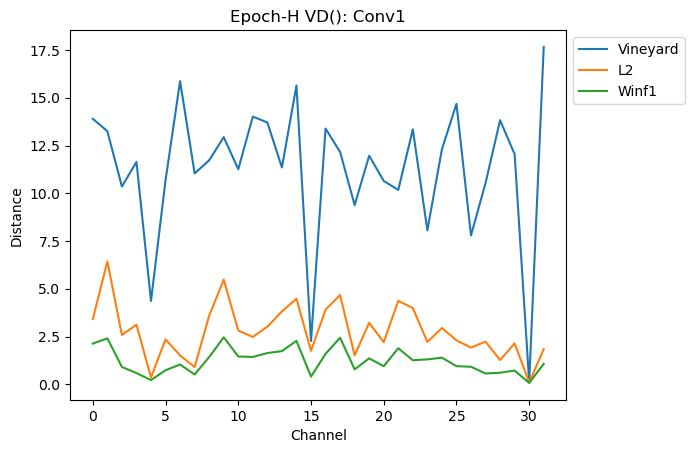

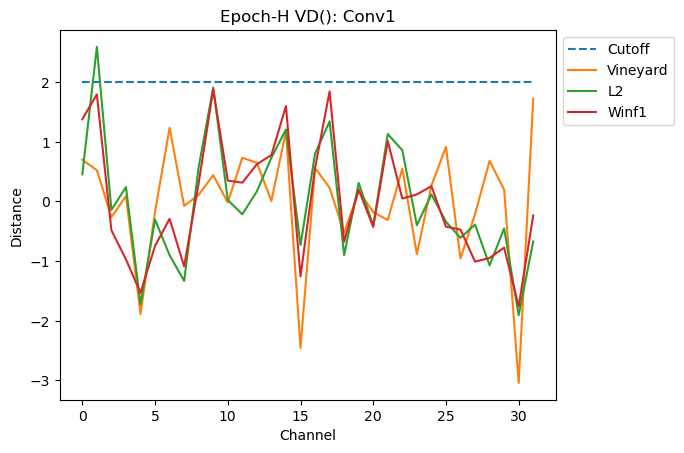

conv2


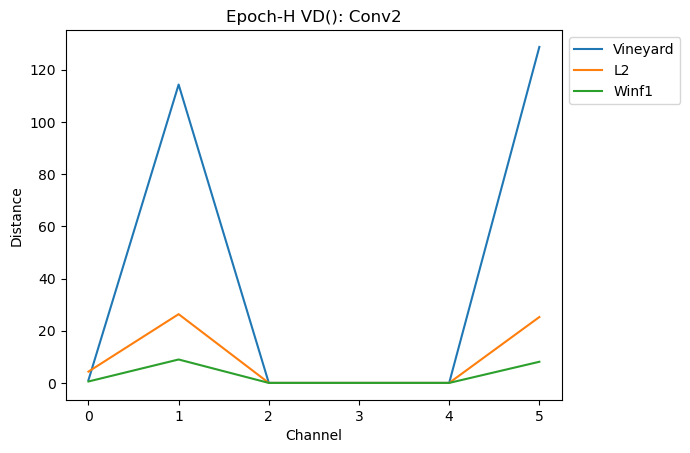

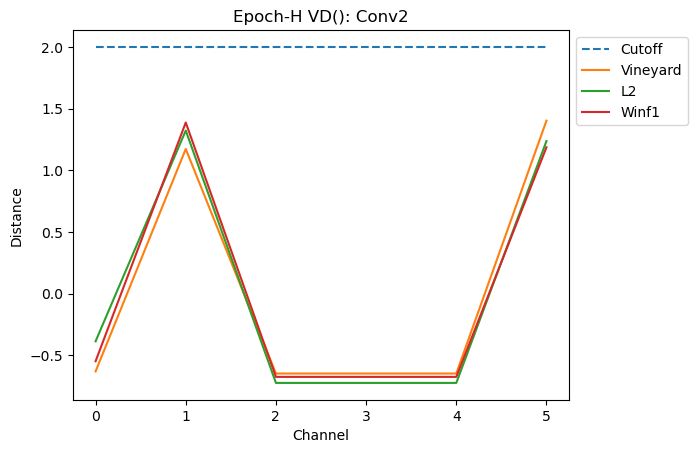

train
Epoch 1/10, Batch 0, Loss: 0.017983026802539825
Epoch 1/10, Batch 10, Loss: 0.014470020309090614
Epoch 1/10, Batch 20, Loss: 0.005351329687982798
Epoch 1/10, Batch 30, Loss: 0.0030139388982206583
Epoch 1/10, Batch 40, Loss: 0.003126597497612238
Epoch 1/10, Batch 50, Loss: 0.002901408588513732
Epoch 1/10, Batch 60, Loss: 0.001475360943004489
Epoch 1/10, Batch 70, Loss: 0.0017307167872786522
Epoch 1/10, Batch 80, Loss: 0.0013129673898220062
Epoch 1/10, Batch 90, Loss: 0.0003810919006355107
Epoch 1/10, Batch 100, Loss: 0.0015669444110244513
Epoch 1/10, Batch 110, Loss: 0.00123444979544729
Epoch 1/10, Batch 120, Loss: 0.0004343150940258056
test
conv1


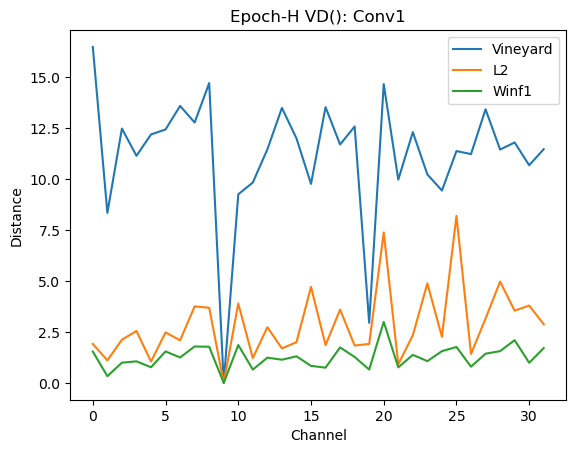

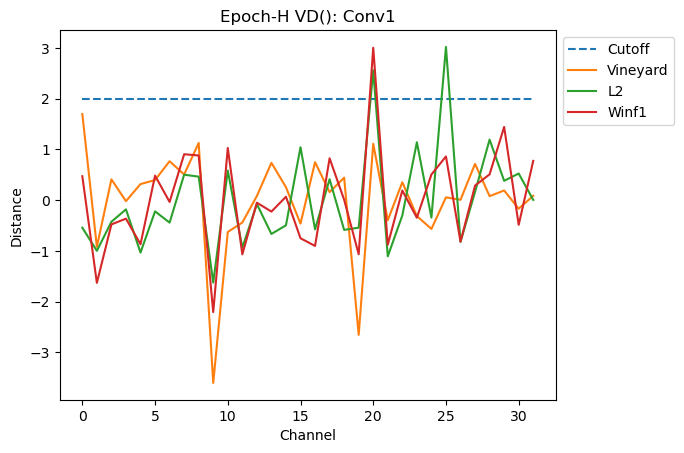

conv2


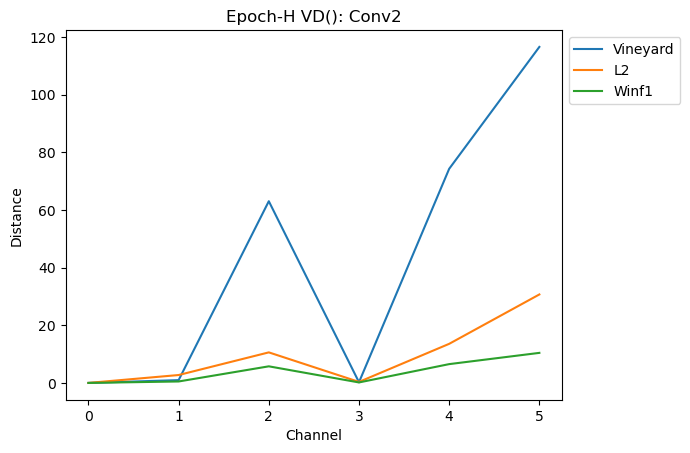

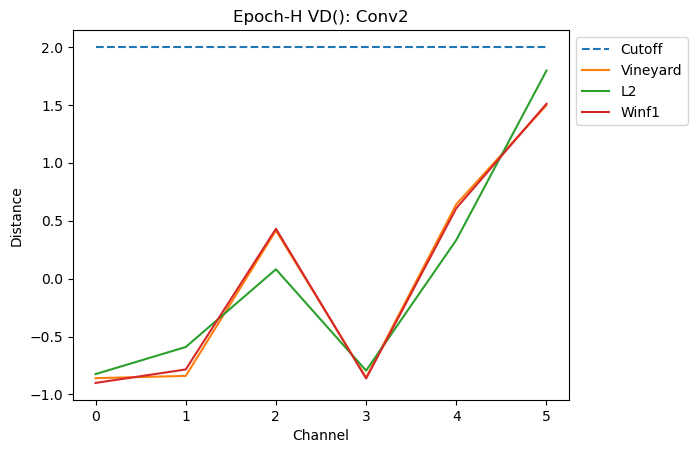

train
Epoch 1/10, Batch 0, Loss: 0.017990868538618088
Epoch 1/10, Batch 10, Loss: 0.008486607111990452
Epoch 1/10, Batch 20, Loss: 0.004376539029181004
Epoch 1/10, Batch 30, Loss: 0.003204254899173975
Epoch 1/10, Batch 40, Loss: 0.0020531932823359966
Epoch 1/10, Batch 50, Loss: 0.0015198929468169808
Epoch 1/10, Batch 60, Loss: 0.0009058435680344701
Epoch 1/10, Batch 70, Loss: 0.0013734705280512571
Epoch 1/10, Batch 80, Loss: 0.0020862254314124584
Epoch 1/10, Batch 90, Loss: 0.0015018389094620943
Epoch 1/10, Batch 100, Loss: 0.001315824338234961
Epoch 1/10, Batch 110, Loss: 0.0012056309496983886
Epoch 1/10, Batch 120, Loss: 0.0014821720542386174
test
conv1


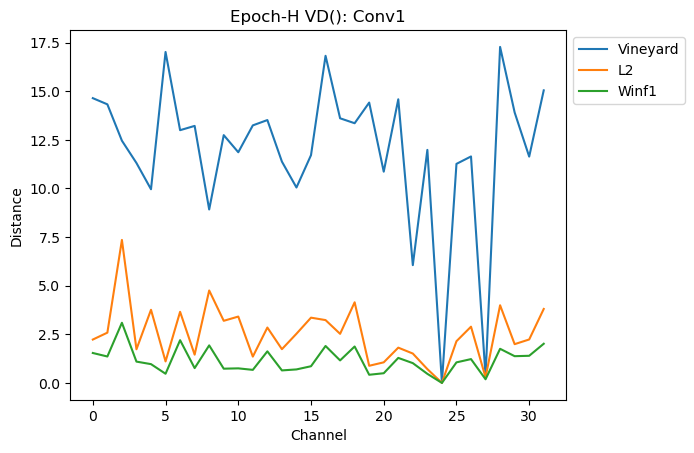

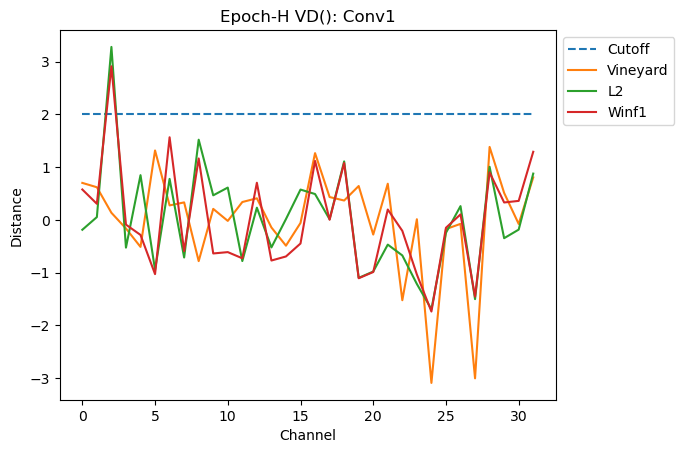

conv2


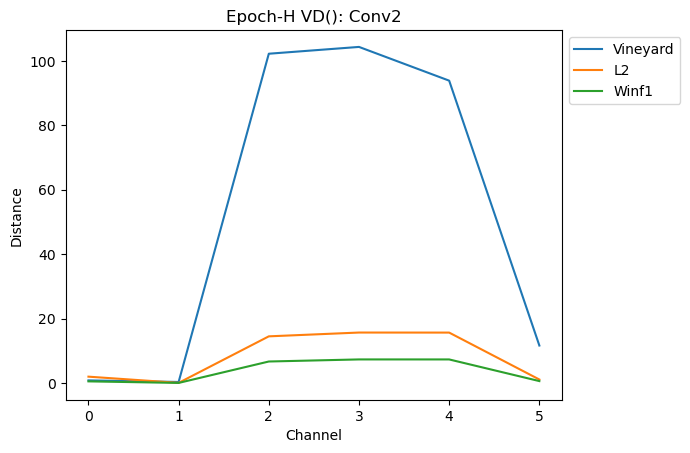

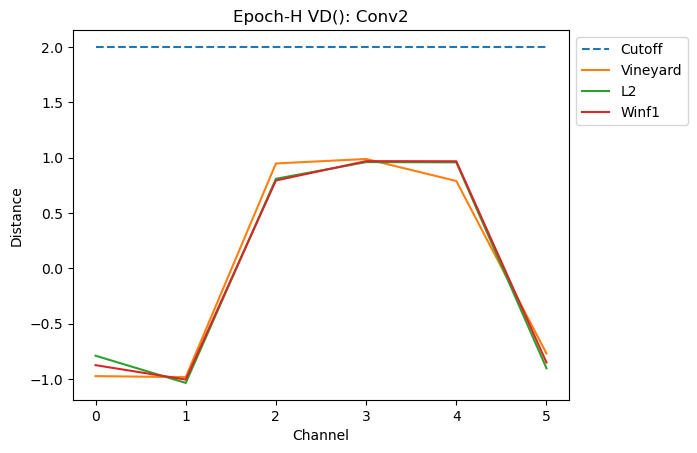

CPU times: user 1h 5min 35s, sys: 2min 9s, total: 1h 7min 44s
Wall time: 14min 21s


In [176]:
%%time
pre = []
for _ in range(5):
    acc, rel, _ = trial([32, 6], max_batch=128)
    pre.append([acc, rel])

In [177]:
np.mean([p[0] for p in pre])

0.95732

In [175]:
0.9697, array([6, 2, 6])],
 [0.9638, array([5, 3, 5])],
 [0.9674, array([5, 4, 4])],
 [0.9718, array([8, 3, 6])],
 [0.9527

0.96508

In [167]:
%%time
accs = [trial([32, 64], max_batch=64, track=False) for _ in range(5)]

train
Epoch 1/10, Batch 0, Loss: 0.017957383766770363


KeyboardInterrupt: 